## Exploring ARIMA time series sensitivity model applications.
**Discovering correlations in historical stock price data.**

In [8]:
%matplotlib inline

# Import dependencies
import pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import minmax_scale

# Config
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
# Load 2-years of daily stock prices across 99 symbols.
def pickle_load(file_path):
    return pickle.load(open(file_path, 'rb'))

history = pickle_load('./history.p')

In [3]:
stock_list = list(history.keys())
print(len(stock_list), stock_list)

history['AAPL'].head()

99 ['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AGN', 'AIG', 'ALL', 'AMGN', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK.B', 'C', 'CAT', 'CELG', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'CVX', 'DHR', 'DIS', 'DUK', 'EMR', 'EXC', 'F', 'FB', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KMI', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTN', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TGT', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'UTX', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM']


,open,high,price,low,close,volume,symbol,symbol_idx
date,,,,,,,,
2016-11-16,106.700000,110.230000,107.69,105.150000,110.010000,3.408643e+07,AAPL,0
2016-11-17,109.820000,110.350000,109.59,108.830000,109.940000,2.353855e+07,AAPL,0
2016-11-18,109.720000,110.540000,110.10,109.660000,110.060000,2.177503e+07,AAPL,0
2016-11-19,109.853333,111.023333,110.40,109.776667,110.616667,2.216502e+07,AAPL,0
2016-11-20,109.986667,111.506667,110.70,109.893333,111.173333,2.255501e+07,AAPL,0


In [4]:
# Unmelt prices to column features

columns = stock_list + ['date']
df = pd.DataFrame(columns=columns)
df = df.set_index('date')

for stock in stock_list:
    df[stock] = history[stock].price

In [5]:
# Sensitivity analysis
# Based on: https://github.com/iRyanBell/YQuantify_py/blob/master/weight_sensitivity.py

def perform_analysis(df, col, sensitivity_ratio=0.3):
  features_all = list(set(df.columns) - set(['date']))
  features = list(set(features_all) - set([col]))
  relative_col_idx = features_all.index(col)
  train = df[:-1]

  model = VAR(endog=train)
  model_fit = model.fit()
  yhat = model_fit.forecast(model_fit.y, steps=2)

  def sensitivity(df, feature, ratio, percentage=0.9):
    df_sen[feature].iloc[-2] = df_sen[feature].iloc[-2] * ratio

    train = df_sen[:-1]

    model_sen = VAR(endog=train)
    model_sen_fit = model_sen.fit()

    yhat_sen_cal = model_sen_fit.forecast(model_sen_fit.y, steps=2)
    return yhat_sen_cal[:, relative_col_idx][-1]

  feature_diff = []
  for feature in features:
    df_sen = df.copy()

    res = sensitivity(df_sen, feature, sensitivity_ratio, percentage=0.1)
    feature_diff.append(yhat[1, relative_col_idx] - res)

  df_sen = pd.DataFrame()
  df_sen['features'] = features
  df_sen['sensitivity'] = minmax_scale(np.array(feature_diff), feature_range=(0,1))

  results = {}
  for idx, attr in enumerate(df_sen['features']):
    results[attr] = df_sen['sensitivity'][idx]

  return pd.melt(pd.DataFrame(results, index=[0])).sort_values(by=['value'], ascending=[False]).reset_index(drop=True)

def find_correlation(symbol, span=28):
    # Perform analysis
    results = perform_analysis(df, col=symbol)
    
    # First result (most correlated)
    symbol_correlation = results['variable'].values[0]
    
    # Last result (least correlated)
    symbol_non_correlation = results['variable'].values[-1]
    
    # Moving average
    symbol_price = history[symbol]['price'].ewm(span=span,min_periods=0,adjust=False,ignore_na=False).mean()
    symbol_correlation_price = history[symbol_correlation]['price'].ewm(span=span,min_periods=0,adjust=False,ignore_na=False).mean()
    symbol_non_correlation_price = history[symbol_non_correlation]['price'].ewm(span=span,min_periods=0,adjust=False,ignore_na=False).mean()
    
    # Scale & plot
    plt.plot(minmax_scale(symbol_price, feature_range=(0,1)), color='blue')
    plt.plot(minmax_scale(symbol_correlation_price, feature_range=(0,1)), color='green')
    plt.plot(minmax_scale(symbol_non_correlation_price, feature_range=(0,1)), color='red')
    plt.title('{}: {}(+) / {}(-)'.format(symbol, symbol_correlation, symbol_non_correlation))
    return results

,variable,value
0,MSFT,1.000000
1,V,0.747399
2,SO,0.585700
3,C,0.562641
4,JPM,0.558938


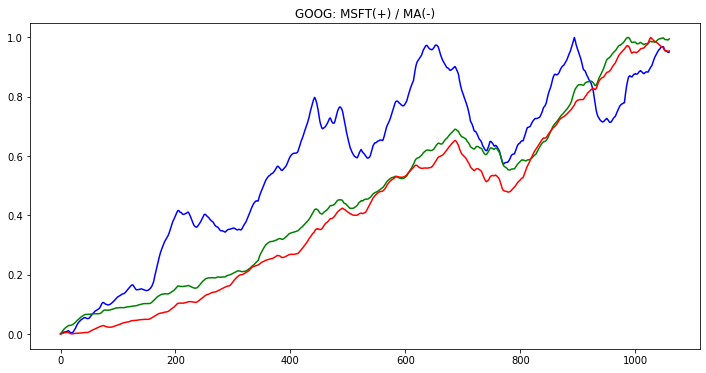

In [9]:
results = find_correlation('GOOG')
results.head()

### We can now discover interesting correlations.

,variable,value
0,V,1.000000
1,COST,0.997340
2,PEP,0.757728
3,SBUX,0.716819
4,DHR,0.591841


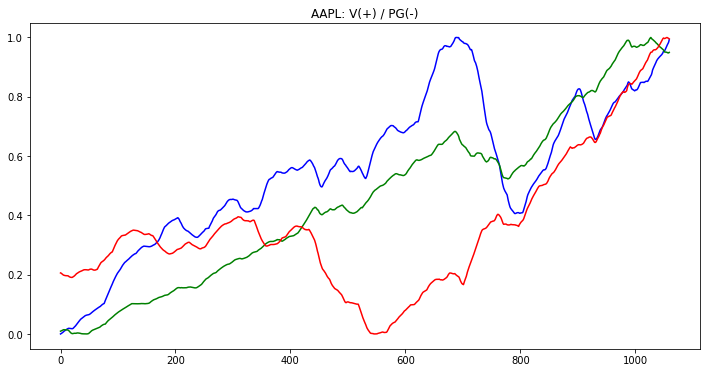

In [10]:
results = find_correlation('AAPL')
results.head()